# Simon Algorithm

Simon's Algorithm is a quantum algorithm that provides an exponential speedup over classical algorithms for solving a particular problem, known as Simon's problem. The problem involves a black-box function $f(x)$ such that:

$$
f(x) = f(x \oplus s)
$$

for a secret string $s$, where $\oplus$ denotes bitwise XOR. The goal of Simon's Algorithm is to determine this secret string $s$.

Simon's problem laid the groundwork for later quantum algorithms, including Shor's Algorithm, and is one of the first examples demonstrating the potential of quantum computing to solve problems more efficiently than classical computing.


In [150]:
import numpy as np
import galois

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Gate
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_aer import AerSimulator
 
from qiskit_aer.noise import (
    NoiseModel,
)

### Simon Function

The following creates a quantum gate for the Simon function $f_s(x) = f_s(x \oplus s)$, where $s$ is a bitstring of length $n$ by defining $f_s(x) = min(x, x \oplus s)$.

- A $4^n \times 4^n$ matrix is constructed to represent the Simon function's operation.
- The operation is encoded as $| \text{target} \rangle | \text{control} \rangle \rightarrow | z \rangle | \text{control} \rangle$, where $z$ is the XORth index of an random permutation of integers.

- The matrix is converted into a unitary gate and added to the quantum circuit.

In [151]:
def simon_function(s: str) -> Gate:
  """
  Create a quantum gate for the Simon function f_s(x) = f_s(x + s) where s is a bitstring of length n.
  Fulfills the promise of Simon's problem.
  Here f_s(x) = rand_permutation[min(x, x + s)] where rand_permutation is a random permutation of the integers 0 to 2^n - 1.
  """

  n = len(s)
  qr = QuantumRegister(n * 2)
  simon_circuit = QuantumCircuit(qr, name="Simon")

  randomness = np.random.permutation(2 ** n)

  # This is the gate matrix for the Simon function
  query_matrix = np.zeros((4 ** n, 4 ** n), dtype=int)

  for control in range(2 ** n):
    for target in range(2 ** n):
      z = target ^ randomness[min(control, control ^ int(s, 2))]

      # The following line is saying that |target>|control> -> |z>|control>
      query_matrix[control + 2 ** n * z, control + 2 ** n * target] = 1
    
  simon_circuit.unitary(query_matrix, qr, label="Simon")

  return simon_circuit.to_gate(label="Simon")

### Simon's Algorithm

After the first layer of Hadamard gates is applied to the $n$ qubits, the state of the system is:

$$
\frac{1}{\sqrt{2^n}} \sum_{x \in \Sigma^n} |0^m\rangle |x\rangle
$$

When the oracle $U_f$ is applied, the state becomes:

$$
\frac{1}{\sqrt{2^n}} \sum_{x \in \Sigma^n} |f(x)\rangle |x\rangle
$$

After applying the second layer of Hadamard gates, the state is:

$$
\frac{1}{\sqrt{2^n}} \sum_{x \in \Sigma^n} \sum_{y \in \Sigma^n} (-1)^{y \cdot x} |f(x)\rangle |y\rangle
$$


In [152]:
def simon_measurements(prob: Gate, k: int, show: bool, noise: bool) -> QuantumCircuit:
  """
  Given a Simon function, return a quantum circuit that measures the first n qubits and returns the results of k shots.
  """

  n = prob.num_qubits // 2
  
  qr = QuantumRegister(n * 2)
  cr = ClassicalRegister(n)
  
  circuit = QuantumCircuit(qr, cr)
  circuit.h(qr[:n])
  circuit.append(prob, qr)

  circuit.h(qr[:n])
  circuit.measure(qr[:n], cr)
  if show:
    display(circuit.draw('mpl'))

  pm = generate_preset_pass_manager(backend=AerSimulator(), optimization_level=1)
  isa_qc = pm.run(circuit)

  noise_model = None
  if noise:
    noise_model = NoiseModel.from_backend(AerSimulator().configuration().backend_name)
    noise_model.add_quantum_error(galois.depolarizing_error(0.01), "id")
    noise_model.add_quantum_error(galois.depolarizing_error(0.01), "u1")

  result = AerSimulator().run(isa_qc, shots=k, memory = True, noise_model=noise_model).result()

  return result.get_memory()

### Post-Processing

Probability of measuring $|y\rangle$ $p(y)$ is given by the squared norm of the amplitude for measuring the string $y$:

$$
p(y) = \left\| \frac{1}{\sqrt{2^n}} \sum_{x \in \Sigma^n} (-1)^{y \cdot x} |f(x)\rangle \right\|^2
$$

Upon simplification, the probability of measuring $|y\rangle$ is:

$$
p(y) = \frac{1}{2^n} \sum_{z \in \text{range}(f)} \left| \sum_{x \in f^{-1}(\{z\})} (-1)^{y \cdot x} \right|^2
$$  

To analyze the probability $p(y)$ of measuring a specific string $y$, we consider the following cases:

$$
p(y) =
\begin{cases}
\frac{1}{2^n} & \text{if } s = 0^n \text{ (one-to-one function)} \\
\frac{1}{2^{n-1}} & \text{if } s \ne 0^n \text{ and } y \cdot s = 0 \\
0 & \text{if } s \ne 0^n \text{ and } y \cdot s = 1
\end{cases}
$$

In [153]:
def simon_algorithm(prob: Gate, r: int, show: bool, noise: bool) -> str:
  measurements = simon_measurements(prob, prob.num_qubits // 2 + r, show, noise)
  if show:
    print(f"Measurements: {measurements}")

  # Convert to 2D array of bits of size (k, n)
  bit_array = np.array([list(map(int, list(x))) for x in measurements])
  
  null_space = galois.GF(2)(bit_array).null_space()
  if show:
    print(f"Null space: {null_space}")

  if len(null_space) == 0:
    return "0" * (prob.num_qubits // 2)
  
  return "".join(map(str, null_space[0]))

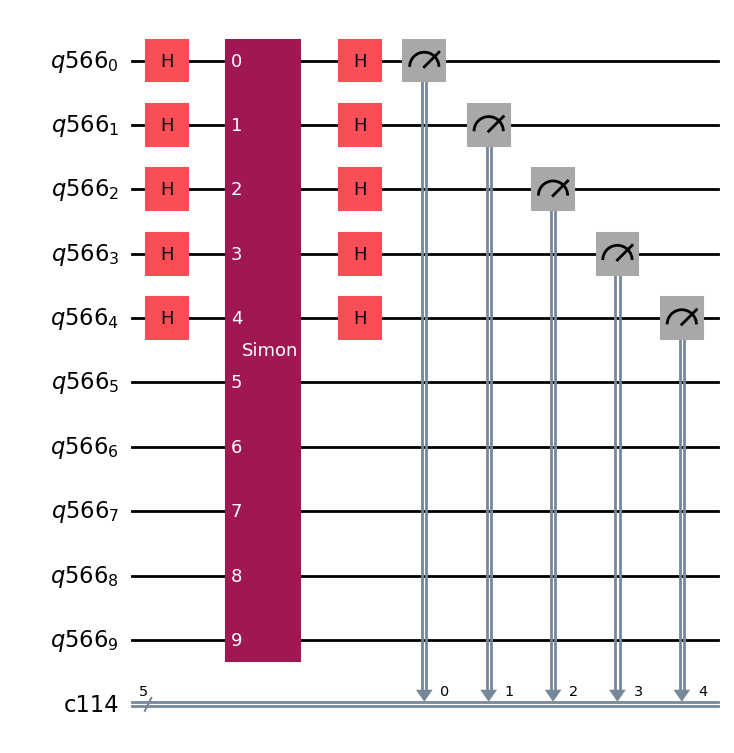

Measurements: ['01001', '01011', '11010', '00100', '11110', '10111', '01001', '10101', '01001', '10011', '01011', '01111', '10111', '11110', '00010']
Null space: [[1 1 0 0 1]]


'11001'

In [154]:
display(simon_algorithm(simon_function("11001"), 10, True, False))

In [155]:
# Run algorithm multiple times to verify correctness
def test_algorithm(n: int, r: int, noise: bool = False):
  count = 0

  for i in range(n):
    s = np.random.randint(2, size=n)
    s_str = "".join(map(str, s))

    ans = simon_algorithm(simon_function(s_str), r, False, False)
    print(f"Expected: {s_str}, Got: {ans}")

    if ans == s_str:
      count += 1

  print(f"Success rate: {count / n}")

In [156]:
print("Testing algorithm")

print("Testing noiseless algorithm")
test_algorithm(5, 10, False)

print("")

print("Testing noisy algorithm")
test_algorithm(5, 10, True)

Testing algorithm
Testing noiseless algorithm
Expected: 00111, Got: 00111
Expected: 00001, Got: 00001
Expected: 00100, Got: 00100
Expected: 01010, Got: 01010
Expected: 01010, Got: 01010
Success rate: 1.0

Testing noisy algorithm
Expected: 11101, Got: 11101
Expected: 10100, Got: 10100
Expected: 01111, Got: 01111
Expected: 01010, Got: 01010
Expected: 00111, Got: 00111
Success rate: 1.0
